<a href="https://colab.research.google.com/github/ginomempin/machine-learning-tutorials/blob/master/src/ImageRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip3 install torch torchvision

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn 
from torchvision import datasets    # Contains the MNIST image dataset
from torchvision import transforms  # Contains common image pre-processing functions

# Reference

[ginomempin / machine-learning-tutorials / docs / ImageRecognition.md](https://github.com/ginomempin/machine-learning-tutorials/blob/master/docs/ImageRecognition.md)

# Setup the Training Set

## Define the Image Transformation

In [0]:
transform = transforms.Compose([
    # No effect on MNIST images, but useful for
    # passing in test images of random sizes.
    transforms.Resize((28, 28)),

    # Convert from Numpy array 0-255 to PyTorch Tensor 0-1
    transforms.ToTensor(),  

    # For each tensor, normalize the values of image size,
    # channel height and channel width. The 1st parameter
    # is the mean and the 2nd parameter is the standard 
    # deviation. Make sure to specify only 1 channel since
    # the MNIST dataset provides grayscale images.
    #
    # We choose 0.5 because we want to normalize the Tensor
    # values from [0, 1] to be [-1, 1].
    #   Ex. If value is 0 (minimum Tensor value)
    #           (0 - 0.5) / 0.5 = -1
    #   Ex. If value is 1 (maximum Tensor value)
    #           (1 - 0.5) / 0.5 = +1
    #
    # Ultimately, we want to normalize to reduce skewness
    # and distorted data values.    
    transforms.Normalize((0.5,), (0.5,))
])

## Define the Dataset

In [84]:
training_dataset = datasets.MNIST(
    root="./data",          # Where the MNIST dataset will be stored
    train=True,             # Create a Training Set
    download=True,          # Downloads from internet and put in `root` directory
    transform=transform     # Image manipulations that will be applied to the images 
)
training_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [85]:
# Provides a way to load the input data into the model in batches.
# Before we pass the entire data into the network every epoch.
 # With 60k data points, this would not be an efficient strategy.
training_loader = torch.utils.data.DataLoader(
    dataset=training_dataset,
    batch_size=100,
    shuffle=True            # Prevent getting stuck into local/false minimums
                            # Make sure that each epoch uses a different batch
)
training_loader

## Plot the Dataset

In [0]:
# To plot, we need to convert the Tensor back to Numpy array.
def img_convert(tensor: torch.Tensor):
    image = tensor.clone().detach().numpy()

    # Convert from 1x28x28 shape to 28x28x1
    # The MNIST dataset are in grayscale, hence only 1 channel.
    # Then each image is 28x28.
    # print(image.shape)
    image = image.transpose(1, 2, 0)

    # De-normalize (reverse the normalization process earlier)
    # Convert it from [-1, 1] back to the original [0, 1]
    image = image * np.array((0.5,)) + np.array((0.5,))
    image = image.clip(0, 1)

    # print(image.shape)
    return image

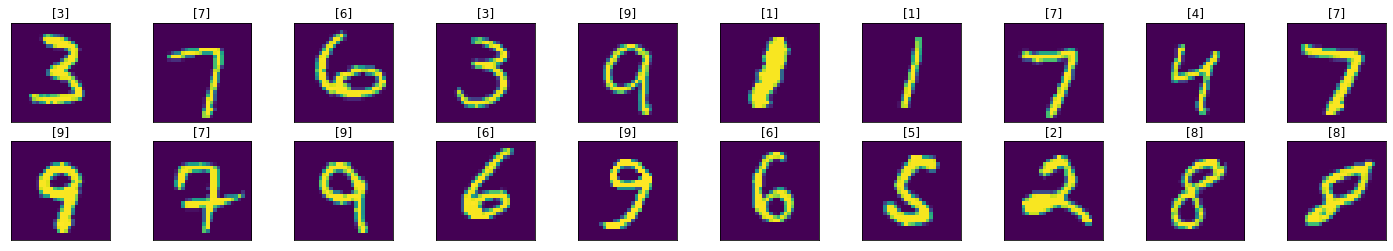

In [87]:
# Create an iterable object
# We can then use `next()` to iteratively get the next batch of data
training_dataset_iter = iter(training_loader)

images, labels = training_dataset_iter.next()
fig = plt.figure(
    figsize=(25, 4),
)

# Plot 20 MNIST images from the current batch
for idx in np.arange(20):
    # Make 2 rows of 10 columns
    # Note that idx is 0-based, but need to be 1-20
    axis = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])  

    # Show the i-th image (using the Tensor -> Numpy conversion)
    img = img_convert(images[idx])
    img = np.squeeze(img)
    plt.imshow(img)

    # Show the labels for each i-th image
    axis.set_title( [labels[idx].item()] )

# Setup the Validation Set

In [110]:
validation_dataset = datasets.MNIST(
    root="./data",          # Where the MNIST dataset will be stored
    train=False,            # Create a Validation Set
    download=True,          # Downloads from internet and put in `root` directory
    transform=transform     # Image manipulations that will be applied to the images 
)
validation_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [111]:
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset,
    batch_size=100,
    shuffle=False
)
validation_loader

# Setup the Network

In [0]:
class Classifier(nn.Module):
    # D_in  : Number of input nodes
    # H1,H2 : Hidden layers
    # D_out : Number of output nodes
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self._linear1 = nn.Linear(D_in, H1)
        self._linear2 = nn.Linear(H1, H2)
        self._linear3 = nn.Linear(H2, D_out)
    
    def forward(self, x):
        res = F.relu(self._linear1(x))      # Use ReLU instead of Sigmoid
        res = F.relu(self._linear2(res))    # Use ReLU instead of Sigmoid
        res = self._linear3(res)            # Don't apply an activation function for the output. 
                                            # What we will get here is the raw output known as 
                                            # the "scores", which is what is needed when dealing 
                                            # with multi-class data sets.
        return res

In [114]:
model = Classifier(
    784,    # 28x28 images
    125,    # Based on empirical observations from previous trainings
    65,     # Based on empirical observations from previous trainings
    10      # 0-9 
)
model

Classifier(
  (_linear1): Linear(in_features=784, out_features=125, bias=True)
  (_linear2): Linear(in_features=125, out_features=65, bias=True)
  (_linear3): Linear(in_features=65, out_features=10, bias=True)
)

# Setup the Loss Function and Optimizer

In [0]:
# Use Cross Entropy Loss for multi-class datasets (instead of BCE for binary data)
criterion = nn.CrossEntropyLoss()  

# Use Gradient Descent to optimize the model.
# Specifically, the Adam optimizer (Adaptive Method Algorithms).
# The Adam optimizer is a combination of 2 extensions of SGD (Stochastic Gradient Descent):
#   Adagrad
#   RMSprop
# What distinguishes it from the SGD is that we had to be careful in choosing the proper
# the learning rate. Too small leads to very slow convergence towards minimum error/loss, 
# while too large can hinder the convergence. When using Adam optimization, it computes 
# the adaptive learning rates for EACH parameter. In practice, Adam is recommended as the
# default optimization algorithm.
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001    # Originally, it was set to 0.01, but the plot of the loss after
                 # training was observed to be fluctuating, meaning the updates to 
                 # the model params were too drastic. When this happens, lower the
                 # learning rate.
)

# Training + Validation

In [116]:
epochs = 15

training_loss_history = []
training_acc_history = []

validation_loss_history = []
validation_acc_history = []

for e in range(epochs):

    # For each epoch, iterate over all the batches to be provided
    # by the training_loader, and keep track of the *total* loss
    # for all batches.
    training_running_loss = 0.0
    training_running_acc = 0.0
    validation_running_loss = 0.0
    validation_running_acc = 0.0

    print("Epoch: {}".format(e + 1))

    # Training Loop
    for images, labels in training_loader:
        # Flatten (1,28,28) into (1,784)
        inputs = images.view(images.shape[0], -1)  # Infer from other dimensions

        # Feedforward through the model
        outputs = model.forward(inputs)

        # Get the current loss
        loss = criterion(outputs, labels)
        training_running_loss += loss.item()

        # Backpropagate the loss to update the model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get the current maximum scored class for each output
        # Returns a tuple
        #   0: The image scores for each of the classes
        #   1: The index of the top score (i.e. which class does each image belong to?)
        _, preds = torch.max(outputs, 1)
        training_running_acc += torch.sum(preds == labels.data)    
            # Example:
            #   If preds  = [2 3 4 5 6]
            #      labels = [2 5 4 5 6]
            #   So only the 2nd prediction is incorrect.
            #   So preds == labels will be [1 0 1 1 1].
    else:  
        epoch_training_loss = training_running_loss / len(training_loader)
        epoch_training_acc  = training_running_acc.float() / len(training_loader)
        # Note that this divide by batch size only works because batch_size = 100.
        # So, dividing the loss/acc by 100 automatically gives a % value.
        # If the batch size is != 100, divide instead by the dataset size
        #   epoch_training_loss = training_running_loss / len(training_loader.dataset)
        #   epoch_training_acc  = training_running_acc.float() / len(training_loader.dataset)        

        training_loss_history.append(epoch_training_loss)
        training_acc_history.append(epoch_training_acc)

        print("Training Loss:{:.4f}, Acc:{:.4f}".format(epoch_training_loss, epoch_training_acc))

    # Validation Loop
    with torch.no_grad():
        for images, labels in validation_loader:
            inputs = images.view(images.shape[0], -1)  # Infer from other dimensions    
            outputs = model.forward(inputs) 
            
            loss = criterion(outputs, labels)
            validation_running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            validation_running_acc += torch.sum(preds == labels.data)
        else:  
            epoch_validation_loss = validation_running_loss / len(validation_loader)
            epoch_validation_acc  = validation_running_acc.float() / len(validation_loader)
            # Note that this divide by batch size only works because batch_size = 100.
            # So, dividing the loss/acc by 100 automatically gives a % value.  
            # If the batch size is != 100, divide instead by the dataset size
            #   epoch_training_loss = validation_running_loss / len(validation_loader.dataset)
            #   epoch_training_acc  = validation_running_acc.float() / len(validation_loader.dataset)                      

            validation_loss_history.append(epoch_validation_loss)
            validation_acc_history.append(epoch_validation_acc)

            print("Validation Loss:{:.4f}, Acc:{:.4f}".format(epoch_validation_loss, epoch_validation_acc))            

Epoch: 1
Training Loss:0.9238, Acc:77.6250
Validation Loss:0.4170, Acc:89.0100
Epoch: 2
Training Loss:0.3726, Acc:89.4500
Validation Loss:0.3182, Acc:91.0400
Epoch: 3
Training Loss:0.3163, Acc:90.8500
Validation Loss:0.2852, Acc:91.7400
Epoch: 4
Training Loss:0.2872, Acc:91.6950
Validation Loss:0.2603, Acc:92.5000
Epoch: 5
Training Loss:0.2629, Acc:92.4017
Validation Loss:0.2429, Acc:93.0900
Epoch: 6
Training Loss:0.2429, Acc:93.0667
Validation Loss:0.2257, Acc:93.6000
Epoch: 7
Training Loss:0.2260, Acc:93.5267
Validation Loss:0.2155, Acc:93.6100
Epoch: 8
Training Loss:0.2099, Acc:94.0467
Validation Loss:0.1958, Acc:94.1700
Epoch: 9
Training Loss:0.1951, Acc:94.4067
Validation Loss:0.1860, Acc:94.6000
Epoch: 10
Training Loss:0.1825, Acc:94.7717
Validation Loss:0.1738, Acc:94.7700
Epoch: 11
Training Loss:0.1709, Acc:95.0633
Validation Loss:0.1660, Acc:95.2100
Epoch: 12
Training Loss:0.1614, Acc:95.3967
Validation Loss:0.1592, Acc:95.2200
Epoch: 13
Training Loss:0.1519, Acc:95.6533
Valid

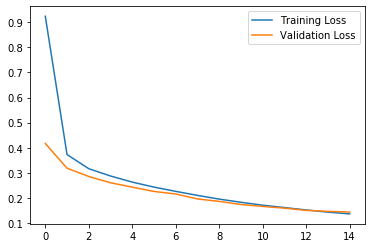

In [117]:
plt.plot(training_loss_history, label="Training Loss")
plt.plot(validation_loss_history, label="Validation Loss")
plt.legend()

The plot already shows that the training and validation errors are converging at around epoch 12. If we continue training the model past epoch 12, the training error becomes **less** than the validation error. This means, past epoch 12, we will have **overfitting** wherein the model is memorizing the training data (low training error) but is unable to accurately classify new input data (high validation error). 

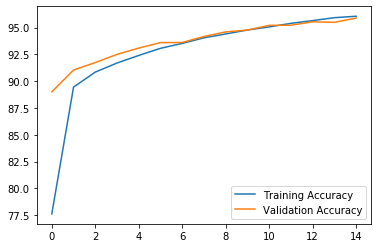

In [118]:
plt.plot(training_acc_history, label="Training Accuracy")
plt.plot(validation_acc_history, label="Validation Accuracy")
plt.legend()

# Testing

Test Links:

* https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg

## Get a Test Image

<Response [200]>


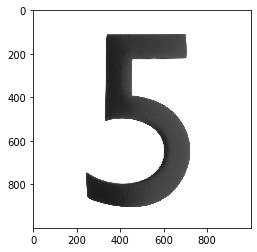

In [148]:
from PIL import Image, ImageOps
import requests

url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
resp = requests.get(url, stream=True)
print(resp)

img = Image.open(resp.raw)
plt.imshow(img)

## Do image preprocessing

The test image must match the image format on which our model was trained on.  
* White text on Black background
* 28x28
* 1-channel grayscale (not RGB)

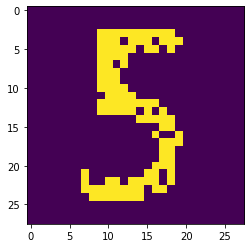

In [149]:
img = ImageOps.invert(img.convert('RGB'))   # black-on-white to white-on-black
img = img.convert('1')                      # grayscale
img = transform(img)                        # apply model's expected image format
img = img_convert(img)                      # convert to Numpy array
plt.imshow(np.squeeze(img))

## Feed to Model

In [152]:
img = torch.Tensor(img)             # Numpy array to Tensor
img = img.view(img.shape[0], -1)    # 1x784
out = model.forward(img)

_, pred = torch.max(out, 1)
print(pred.item())

5
